In [1]:
from skeletonization.skeletonizer import Skeletonizer
import numpy as np
import cv2
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from skeletonization.bonetypes import common

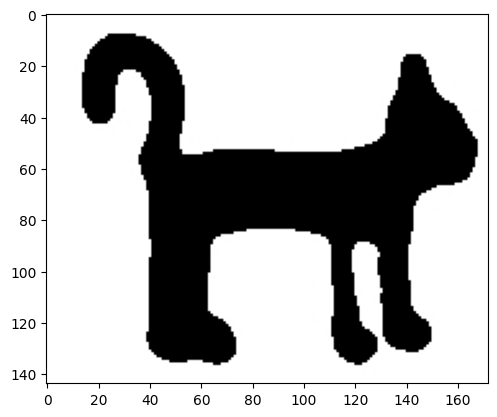

In [2]:
img = cv2.imread('cat_1_mask_classical.jpg')
img = ~img
plt.imshow(img)
plt.show()

In [3]:
skeletonizer = Skeletonizer(img)
skeleton = skeletonizer.skeletonize(30,3,10)

In [4]:
segmented = cv2.imread('cat_1_segmented_data.jpg',cv2.IMREAD_GRAYSCALE)
segmented = cv2.resize(segmented,(img.shape[1],img.shape[0]))
skeleton.identify(segmented)

In [5]:
joint_type_to_color = {
    common.JointType.LIMB : 'b',
    common.JointType.BODY : 'g',
    common.JointType.HEAD : 'r',
    common.JointType.WING : 'm',
    common.JointType.MIXED : 'c',
    common.JointType.NONE : 'y'
}

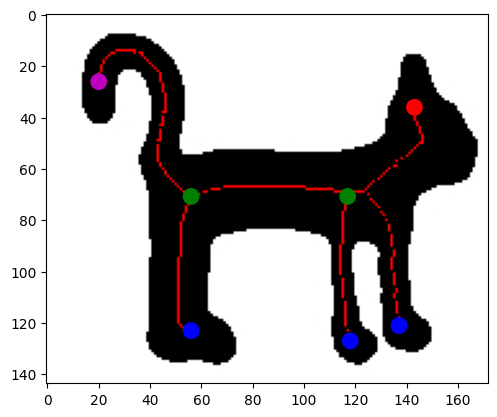

In [6]:
visiualize = np.copy(img)

for bone in skeleton.get_bones():
    for point in bone[1]:
        visiualize[int(point[1])][int(point[0])] = [255,0,0]

fig, ax = plt.subplots()
ax.imshow(visiualize)
for joint in skeleton.joints:
    circle = patches.Circle((joint.position[0], joint.position[1]),3,color=joint_type_to_color[joint.type])
    ax.add_patch(circle)
plt.show()

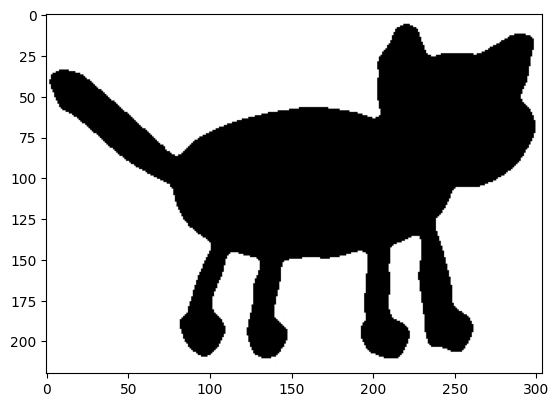

In [7]:
prototype_img = cv2.imread("cat_proto_mask.jpg",cv2.IMREAD_COLOR)
prototype_img = ~prototype_img
plt.imshow(prototype_img)
plt.show()

In [8]:
proto_skeletonizer = Skeletonizer(prototype_img)
proto_skeleton = proto_skeletonizer.skeletonize(30,3,10)
proto_segmented = cv2.imread('cat_proto_segment.jpg',cv2.IMREAD_GRAYSCALE)
proto_segmented = cv2.resize(proto_segmented,(prototype_img.shape[1],prototype_img.shape[0]))
proto_skeleton.identify(proto_segmented)

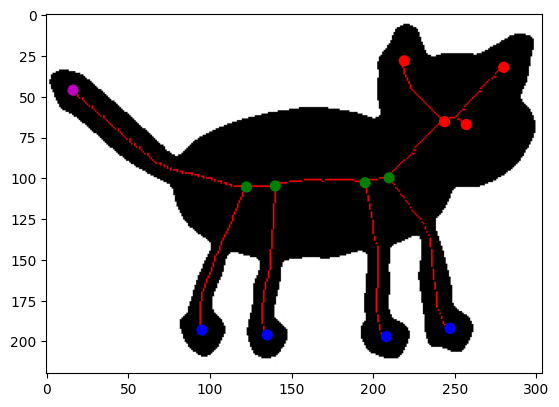

In [9]:
visiualize_proto = np.copy(prototype_img)

for bone in proto_skeleton.get_bones():
    for point in bone[1]:
        visiualize_proto[int(point[1])][int(point[0])] = [255,0,0]

fig, ax = plt.subplots()
ax.imshow(visiualize_proto)
for joint in proto_skeleton.joints:
    circle = patches.Circle((joint.position[0], joint.position[1]),3,color=joint_type_to_color[joint.type])
    ax.add_patch(circle)
plt.show()